# IMDB Movie Review Analysis Plan

## 1. Data Loading and Initial EDA
- Load training and test datasets
- Check basic dataset information (shape, data types, missing values)
- Display sample reviews
- Basic text statistics:
  - Review length distribution
  - Word count analysis

## 2. Text Preprocessing
- Basic cleaning:
  - Remove HTML tags
  - Handle special characters
  - Convert to lowercase
- Text normalization:
  - Remove stopwords
  - Lemmatization/Stemming

## 3. Baseline Model - LogisticRegression with TF-IDF
- TF-IDF vectorization (unigrams, bigrams, trigrams)
- Train/validation split
- Model training and evaluation:
  - Accuracy
  - F1 Score
  - Confusion Matrix
- Feature importance analysis:
  - Most influential positive/negative words
  - Visualization of important features

## 4. Advanced Model - DistilBERT
- Dataset preparation:
  - Create custom dataset class
  - Tokenization
  - Padding
  - Attention masks
- Model architecture:
  - Fine-tune pretrained DistilBERT
  - Add classification head
- Training setup:
  - Loss function
  - Optimizer (AdamW )
  - Learning rate scheduler

- Model evaluation:
  - Compare with baseline
  - Error analysis
  



Training Dataset Statistics:
Total number of reviews: 100
Average word count: 229.11
Median word count: 177.00


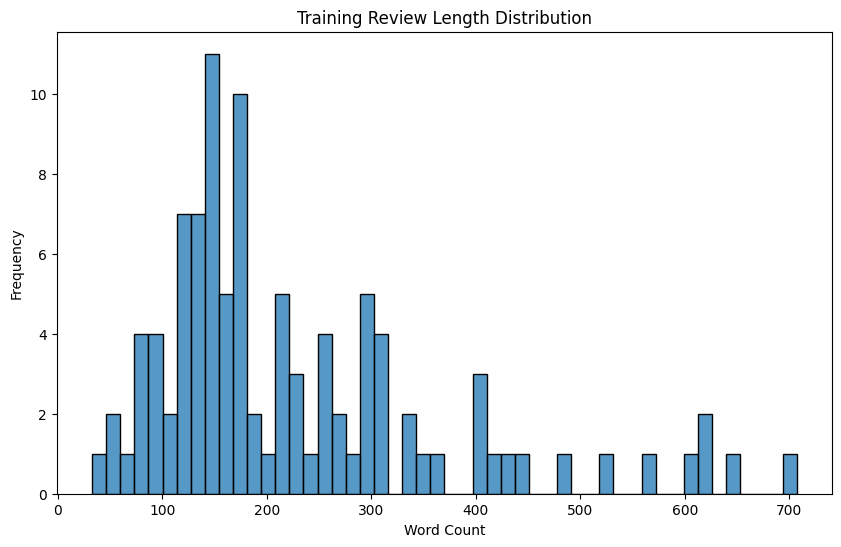

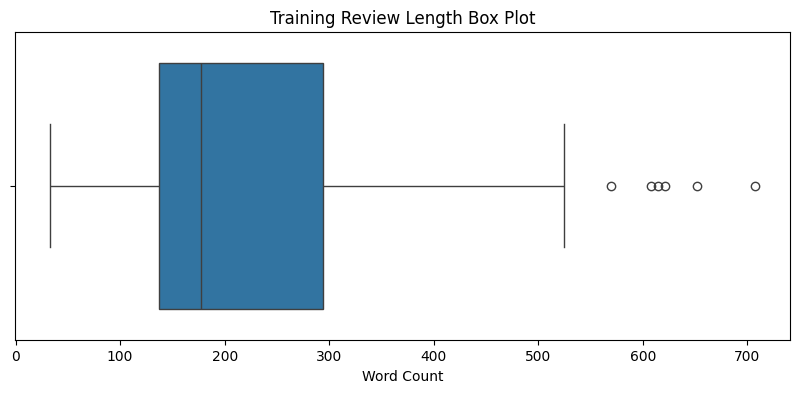


Test Dataset Statistics:
Total number of reviews: 25000
Average word count: 230.95
Median word count: 173.00


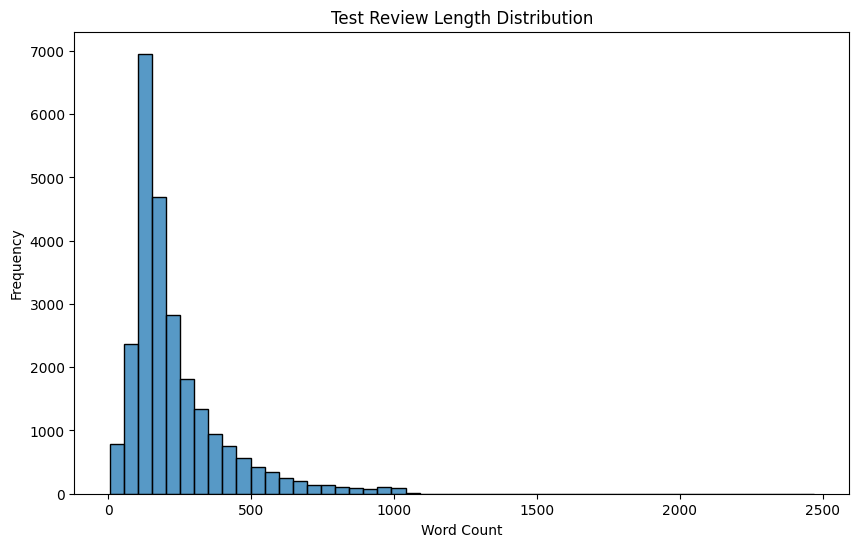

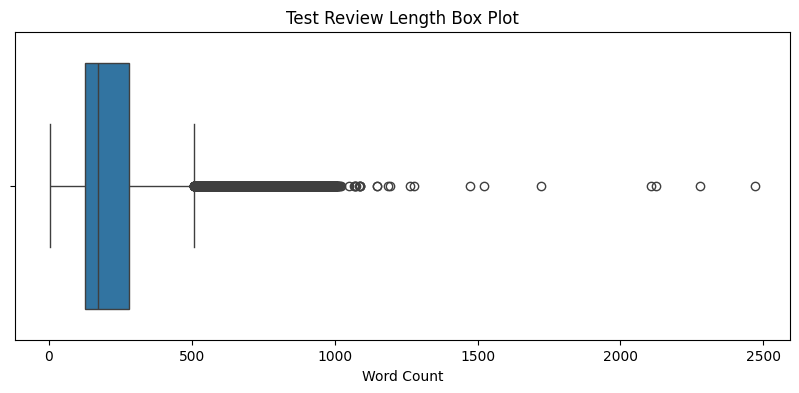

In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
import re
import warnings
warnings.filterwarnings('ignore')

# Data Loading
def load_imdb_data(train_path, test_path):
    """
    Load IMDB dataset and perform basic preprocessing
    """
    # Load datasets
    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)

    return train_df, test_df

def clean_html(text):
    """
    Remove HTML tags from text
    """
    soup = BeautifulSoup(text, 'html.parser')
    return soup.get_text()

def basic_text_cleaning(text):
    """
    Perform basic text cleaning
    """
    # Remove HTML tags
    text = clean_html(text)
    # Convert to lowercase
    text = text.lower()
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text

def plot_length_distribution(df, title=""):
    """
    Plot the distribution of review lengths
    """
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x='word_count', bins=50)
    plt.title(f'{title} Review Length Distribution')
    plt.xlabel('Word Count')
    plt.ylabel('Frequency')
    plt.show()

    # Add box plot for better visualization of outliers
    plt.figure(figsize=(10, 4))
    sns.boxplot(data=df, x='word_count')
    plt.title(f'{title} Review Length Box Plot')
    plt.xlabel('Word Count')
    plt.show()

def analyze_reviews(df, title=""):
    """
    Perform basic analysis on reviews
    """
    # Add word count
    df['word_count'] = df['review'].apply(lambda x: len(str(x).split()))

    # Basic statistics
    print(f"\n{title} Dataset Statistics:")
    print(f"Total number of reviews: {len(df)}")
    print(f"Average word count: {df['word_count'].mean():.2f}")
    print(f"Median word count: {df['word_count'].median():.2f}")

    # Plot length distribution
    plot_length_distribution(df, title)

    return df

# Load and prepare the data
train_df, test_df = load_imdb_data('imdb_train.csv', 'imdb_test.csv')

# Clean the text
train_df['cleaned_review'] = train_df['review'].apply(basic_text_cleaning)
test_df['cleaned_review'] = test_df['review'].apply(basic_text_cleaning)

# Analyze both datasets
train_df = analyze_reviews(train_df, "Training")
test_df = analyze_reviews(test_df, "Test")



由于训练集较小(100条)而测试集较大(25000条)，这个模型可能会面临一些挑战，如可能会出现过拟合

Vectorizing text data...

Training model...

Cross-validation scores: [0.75 0.8  0.65 0.7  0.65]
Average CV score: 0.7100000000000001

Training Set Performance:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        50
         1.0       1.00      1.00      1.00        50

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100


Test Set Performance:
              precision    recall  f1-score   support

         0.0       0.68      0.75      0.71     12500
         1.0       0.72      0.65      0.68     12500

    accuracy                           0.70     25000
   macro avg       0.70      0.70      0.70     25000
weighted avg       0.70      0.70      0.70     25000


Training Set Confusion Matrix:


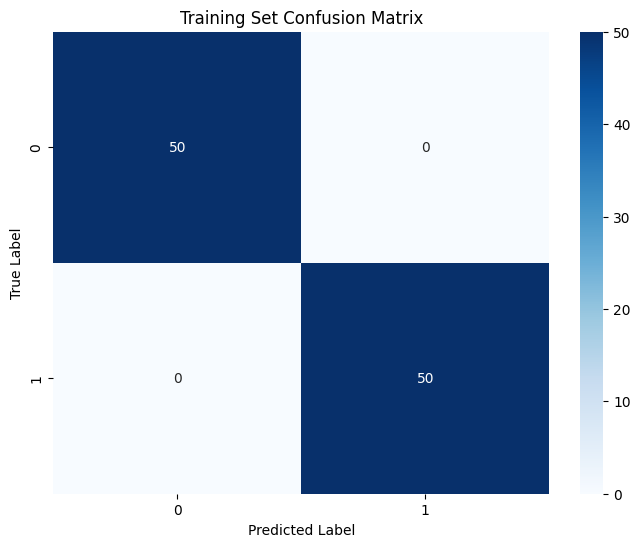


Test Set Confusion Matrix:


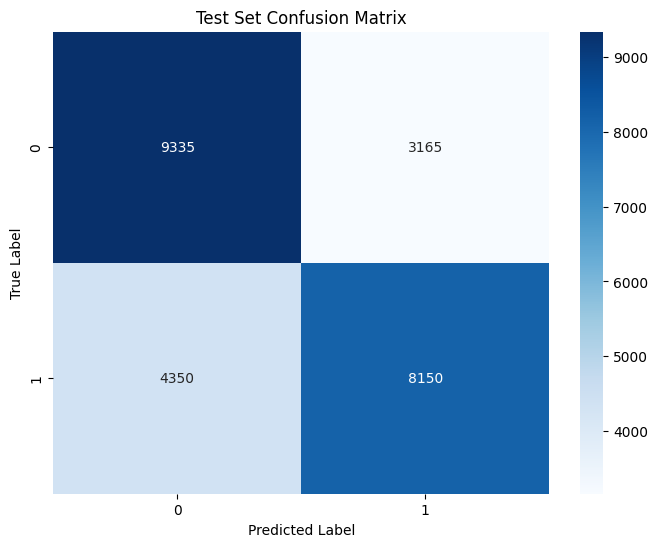


Analyzing feature importance...


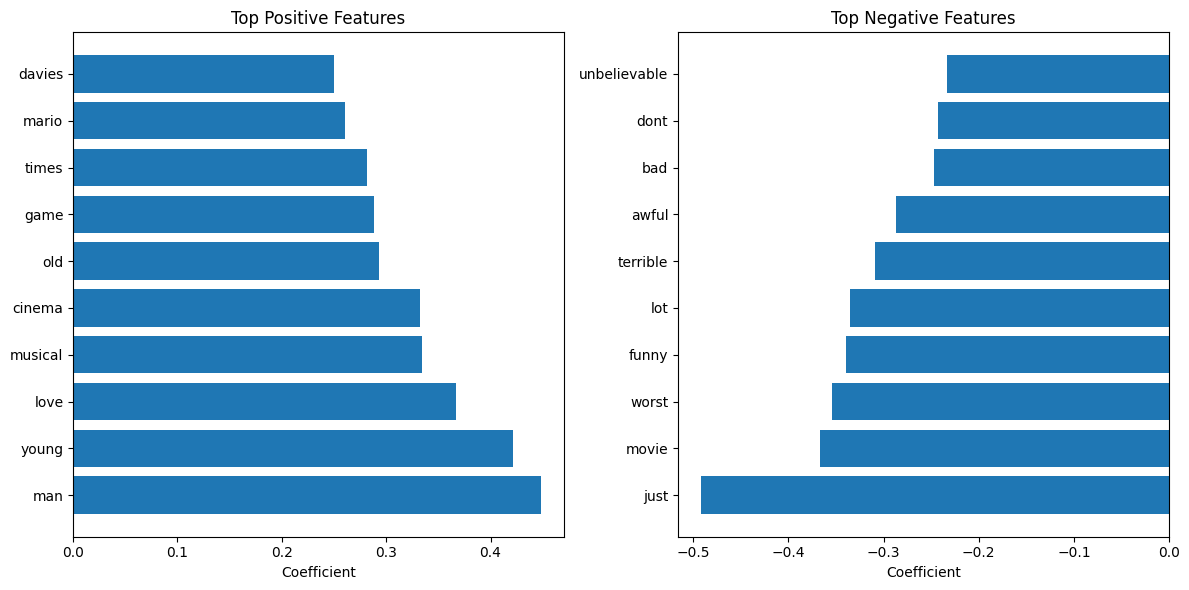


Top Positive Features:
      feature  coefficient
984       man     0.448081
2993    young     0.421079
961      love     0.367041
1262  musical     0.334199
233    cinema     0.332719

Top Negative Features:
     feature  coefficient
853     just    -0.491369
1121   movie    -0.366498
2975   worst    -0.354176
605    funny    -0.339177
956      lot    -0.335580


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

def prepare_data_for_modeling(train_reviews, test_reviews=None):
    """
    Prepare text data for modeling using TF-IDF
    """
    # Create TF-IDF vectorizer
    tfidf = TfidfVectorizer(
        max_features=3000,  # 减少特征数量，避免过拟合
        ngram_range=(1, 2),  # 使用unigrams和bigrams
        stop_words='english'
    )

    # Fit and transform training data
    X_train = tfidf.fit_transform(train_reviews)

    # Transform test data if provided
    X_test = None
    if test_reviews is not None:
        X_test = tfidf.transform(test_reviews)

    return X_train, X_test, tfidf

def train_and_evaluate_model(X_train, y_train, X_test=None, y_test=None):
    """
    Train and evaluate logistic regression model
    """
    # Initialize model with balanced class weights
    model = LogisticRegression(
        max_iter=1000,
        random_state=42,
        class_weight='balanced',  # 处理类别平衡
        C=1.0  # 正则化强度的倒数
    )

    # Perform cross-validation on training set
    cv_scores = cross_val_score(model, X_train, y_train, cv=5)
    print("\nCross-validation scores:", cv_scores)
    print("Average CV score:", cv_scores.mean())

    # Train the model on full training set
    model.fit(X_train, y_train)

    # Evaluate on training set
    train_preds = model.predict(X_train)
    print("\nTraining Set Performance:")
    print(classification_report(y_train, train_preds))

    # Evaluate on test set if provided
    if X_test is not None and y_test is not None:
        test_preds = model.predict(X_test)
        print("\nTest Set Performance:")
        print(classification_report(y_test, test_preds))

    return model

def plot_confusion_matrix(y_true, y_pred, title=""):
    """
    Plot confusion matrix
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{title} Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def analyze_feature_importance(model, vectorizer, n_top=10):
    """
    Analyze and visualize most important features
    """
    coefficients = model.coef_[0]
    feature_names = vectorizer.get_feature_names_out()

    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'coefficient': coefficients
    })

    feature_importance['abs_coef'] = abs(feature_importance['coefficient'])
    feature_importance = feature_importance.sort_values('abs_coef', ascending=False)

    plt.figure(figsize=(12, 6))

    # Positive features
    plt.subplot(1, 2, 1)
    pos_features = feature_importance[feature_importance['coefficient'] > 0].head(n_top)
    plt.barh(pos_features['feature'], pos_features['coefficient'])
    plt.title('Top Positive Features')
    plt.xlabel('Coefficient')

    # Negative features
    plt.subplot(1, 2, 2)
    neg_features = feature_importance[feature_importance['coefficient'] < 0].head(n_top)
    plt.barh(neg_features['feature'], neg_features['coefficient'])
    plt.title('Top Negative Features')
    plt.xlabel('Coefficient')

    plt.tight_layout()
    plt.show()

    print("\nTop Positive Features:")
    print(pos_features[['feature', 'coefficient']].head())
    print("\nTop Negative Features:")
    print(neg_features[['feature', 'coefficient']].head())

# 创建标签
train_labels = np.concatenate([np.ones(50), np.zeros(50)])  # 训练集标签
test_labels = np.concatenate([np.ones(12500), np.zeros(12500)])  # 测试集标签

# 准备数据
print("Vectorizing text data...")
X_train, X_test, vectorizer = prepare_data_for_modeling(
    train_df['cleaned_review'],
    test_df['cleaned_review']
)

# 训练和评估模型
print("\nTraining model...")
model = train_and_evaluate_model(X_train, train_labels, X_test, test_labels)

# 绘制训练集的混淆矩阵
print("\nTraining Set Confusion Matrix:")
plot_confusion_matrix(train_labels, model.predict(X_train), "Training Set")

# 绘制测试集的混淆矩阵
print("\nTest Set Confusion Matrix:")
plot_confusion_matrix(test_labels, model.predict(X_test), "Test Set")

# 分析特征重要性
print("\nAnalyzing feature importance...")
analyze_feature_importance(model, vectorizer)

改动：

TF-IDF特征提取：

- 减少特征数量到2000
- 只使用unigrams（去掉bigrams）
- 添加了max_df和min_df参数来过滤极端频率的词
- 增加了停用词过滤


逻辑回归模型：

- 增加了正则化强度（C=0.1）
- 明确使用L2正则化
- 保持类别权重平衡

Vectorizing text data...

Training model...

Cross-validation scores: [0.75 0.85 0.75 0.8  0.7 ]
Average CV score: 0.770 (+/- 0.102)

Training Set Performance:
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98        50
         1.0       0.98      0.98      0.98        50

    accuracy                           0.98       100
   macro avg       0.98      0.98      0.98       100
weighted avg       0.98      0.98      0.98       100


Test Set Performance:
              precision    recall  f1-score   support

         0.0       0.69      0.73      0.71     12500
         1.0       0.71      0.67      0.69     12500

    accuracy                           0.70     25000
   macro avg       0.70      0.70      0.70     25000
weighted avg       0.70      0.70      0.70     25000


Training Set Confusion Matrix:


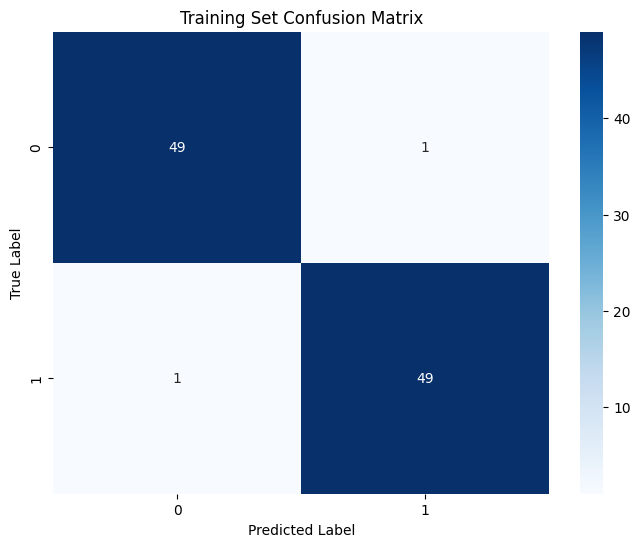


Test Set Confusion Matrix:


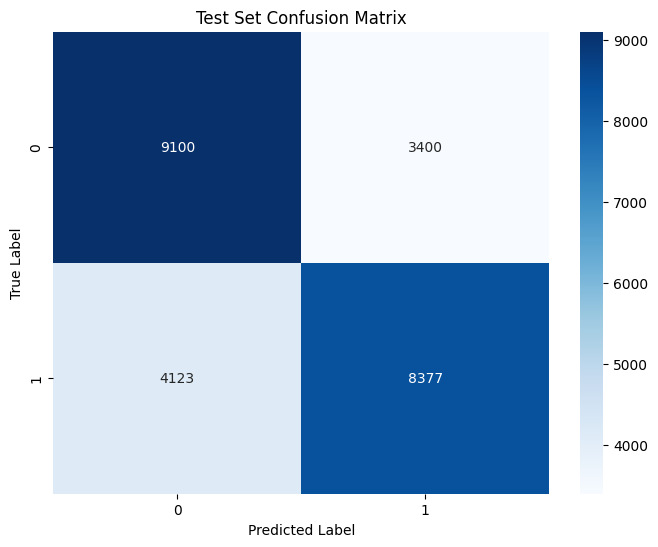


Analyzing feature importance...


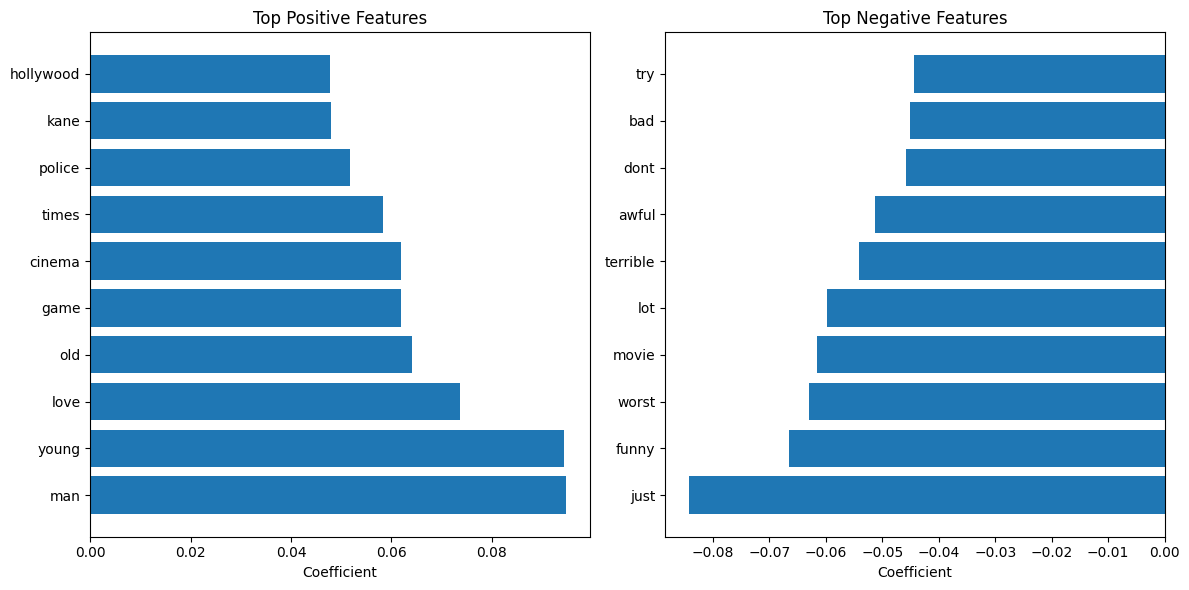


Top Positive Features:
    feature  coefficient
362     man     0.094815
717   young     0.094463
352    love     0.073678
416     old     0.064068
220    game     0.061929

Top Negative Features:
    feature  coefficient
301    just    -0.084256
218   funny    -0.066595
706   worst    -0.062963
391   movie    -0.061477
350     lot    -0.059858


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

def prepare_data_for_modeling(train_reviews, test_reviews=None):
    """
    Prepare text data for modeling using TF-IDF with simplified features
    """
    tfidf = TfidfVectorizer(
        max_features=2000,  # 减少特征数量
        ngram_range=(1, 1),  # 只使用unigrams
        stop_words='english',
        max_df=0.9,         # 忽略在90%以上文档中出现的词
        min_df=3            # 忽略出现次数少于3次的词
    )

    X_train = tfidf.fit_transform(train_reviews)
    X_test = None
    if test_reviews is not None:
        X_test = tfidf.transform(test_reviews)

    return X_train, X_test, tfidf

def train_and_evaluate_model(X_train, y_train, X_test=None, y_test=None):
    """
    Train and evaluate logistic regression model with stronger regularization
    """
    # 增加正则化强度（减小C值）
    model = LogisticRegression(
        C=0.1,              # 增加正则化强度
        max_iter=1000,
        random_state=42,
        class_weight='balanced',
        penalty='l2'        # 使用L2正则化
    )

    # 交叉验证
    cv_scores = cross_val_score(model, X_train, y_train, cv=5)
    print("\nCross-validation scores:", cv_scores)
    print("Average CV score: {:.3f} (+/- {:.3f})".format(
        cv_scores.mean(), cv_scores.std() * 2))

    # 训练模型
    model.fit(X_train, y_train)

    # 评估训练集
    train_preds = model.predict(X_train)
    print("\nTraining Set Performance:")
    print(classification_report(y_train, train_preds))

    # 评估测试集
    if X_test is not None and y_test is not None:
        test_preds = model.predict(X_test)
        print("\nTest Set Performance:")
        print(classification_report(y_test, test_preds))

    return model

def plot_confusion_matrix(y_true, y_pred, title=""):
    """
    Plot confusion matrix
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{title} Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def analyze_feature_importance(model, vectorizer, n_top=10):
    """
    Analyze and visualize most important features
    """
    coefficients = model.coef_[0]
    feature_names = vectorizer.get_feature_names_out()

    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'coefficient': coefficients
    })

    feature_importance['abs_coef'] = abs(feature_importance['coefficient'])
    feature_importance = feature_importance.sort_values('abs_coef', ascending=False)

    plt.figure(figsize=(12, 6))

    # Positive features
    plt.subplot(1, 2, 1)
    pos_features = feature_importance[feature_importance['coefficient'] > 0].head(n_top)
    plt.barh(pos_features['feature'], pos_features['coefficient'])
    plt.title('Top Positive Features')
    plt.xlabel('Coefficient')

    # Negative features
    plt.subplot(1, 2, 2)
    neg_features = feature_importance[feature_importance['coefficient'] < 0].head(n_top)
    plt.barh(neg_features['feature'], neg_features['coefficient'])
    plt.title('Top Negative Features')
    plt.xlabel('Coefficient')

    plt.tight_layout()
    plt.show()

    print("\nTop Positive Features:")
    print(pos_features[['feature', 'coefficient']].head())
    print("\nTop Negative Features:")
    print(neg_features[['feature', 'coefficient']].head())

# 创建标签
train_labels = np.concatenate([np.ones(50), np.zeros(50)])
test_labels = np.concatenate([np.ones(12500), np.zeros(12500)])

# 准备数据
print("Vectorizing text data...")
X_train, X_test, vectorizer = prepare_data_for_modeling(
    train_df['cleaned_review'],
    test_df['cleaned_review']
)

# 训练和评估模型
print("\nTraining model...")
model = train_and_evaluate_model(X_train, train_labels, X_test, test_labels)

# 绘制混淆矩阵
print("\nTraining Set Confusion Matrix:")
plot_confusion_matrix(train_labels, model.predict(X_train), "Training Set")

print("\nTest Set Confusion Matrix:")
plot_confusion_matrix(test_labels, model.predict(X_test), "Test Set")

# 分析特征重要性
print("\nAnalyzing feature importance...")
analyze_feature_importance(model, vectorizer)

低GPU ver 低GPU ver，同时由于样本过小，增加dropout防止过拟合，使用StepLR防止震荡

构建模型的步骤：

数据预处理：

- 使用 DistilBERT 分词器对输入文本进行分词，生成 input_ids 和 attention_mask。
- 构建自定义数据集类 CustomDataset，将文本和标签转化为 PyTorch 张量。
- 使用 DataLoader 加载数据，方便批量训练。

模型架构：

- 我选择了 DistilBERT 作为特征提取器，并在其基础上加上了一个分类头。
- 通过添加 Dropout 层来减少模型的过拟合，提高泛化能力。
- 使用了 AdamW 优化器，并选择了交叉熵损失函数作为分类任务的损失函数。

优化器与调度：

- 使用 AdamW 优化器来适应 Transformer 模型的训练特点。
- 使用了 StepLR 调度器，每隔一定步数降低学习率，以帮助模型在训练后期更加稳定地收敛。

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizer

class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        text = self.texts[index]
        label = self.labels[index]

        encoding = self.tokenizer(
            text,
            max_length=self.max_len,
            truncation=True,
            padding='max_length',
            return_tensors="pt"
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'targets': torch.tensor(label, dtype=torch.long)
        }

# 加载预训练的 DistilBERT 分词器
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
MAX_LEN = 128  # 设置最大序列长度
BATCH_SIZE = 4  # 批量大小

# 创建数据集
train_dataset = CustomDataset(
    texts=train_df['cleaned_review'].tolist(),
    labels=train_labels,
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

test_dataset = CustomDataset(
    texts=test_df['cleaned_review'].tolist(),
    labels=test_labels,
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

# 创建数据加载器
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [ ]:
from transformers import AutoConfig, AutoModel
import torch.nn as nn
import torch.nn.functional as F

class CustomDistilBert(nn.Module):
    def __init__(self, pretrained_model_name='distilbert-base-uncased', num_classes=2, dropout_prob=0.5):
        super(CustomDistilBert, self).__init__()
        config = AutoConfig.from_pretrained(pretrained_model_name)
        self.distilbert = AutoModel.from_pretrained(pretrained_model_name, config=config)
        self.pre_classifier = nn.Linear(config.dim, config.dim)
        self.classifier = nn.Linear(config.dim, num_classes)
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, input_ids, attention_mask=None):
        distilbert_output = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = distilbert_output[0]  # Batch x Seq_len x Hidden_dim
        pooled_output = hidden_state[:, 0]  # [CLS] token vector
        pooled_output = F.relu(self.pre_classifier(pooled_output))
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits

In [ ]:
from torch.optim.lr_scheduler import StepLR
from transformers import AdamW

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = CustomDistilBert(pretrained_model_name='distilbert-base-uncased', num_classes=2, dropout_prob=0.3)

model = model.to(device)

# 定义优化器
optimizer = AdamW(model.parameters(), lr=5e-6) #增加

# 定义学习率调度器
scheduler = StepLR(optimizer, step_size=2, gamma=0.5)  # 每2轮减小一半学习率

In [ ]:
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score

# 定义训练函数
def train_epoch(model, data_loader, optimizer, device, criterion):
    model.train()
    total_loss = 0

    for batch in data_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['targets'].to(device)

        optimizer.zero_grad()

        # 前向传播
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = criterion(outputs, labels)

        # 反向传播
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(data_loader)

# 定义评估函数
def evaluate(model, data_loader, device, criterion):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['targets'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    return total_loss / len(data_loader), accuracy


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_performance(y_true, y_pred):
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

# 将训练数据拆分为训练集和验证集
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_df['cleaned_review'].tolist(),
    train_labels,
    test_size=0.2,
    random_state=42
)

# 创建验证集数据集
val_dataset = CustomDataset(
    texts=val_texts,
    labels=val_labels,
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

# 创建验证集数据加载器
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)


Epoch 1/2
Training Loss: 0.6973
Validation Loss: 0.6817, Validation Accuracy: 0.6000
Epoch 2/2
Training Loss: 0.6802
Validation Loss: 0.6869, Validation Accuracy: 0.5000
Test Loss: 0.6860, Test Accuracy: 0.5374

Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.97      0.68     12500
           1       0.77      0.11      0.19     12500

    accuracy                           0.54     25000
   macro avg       0.65      0.54      0.43     25000
weighted avg       0.65      0.54      0.43     25000



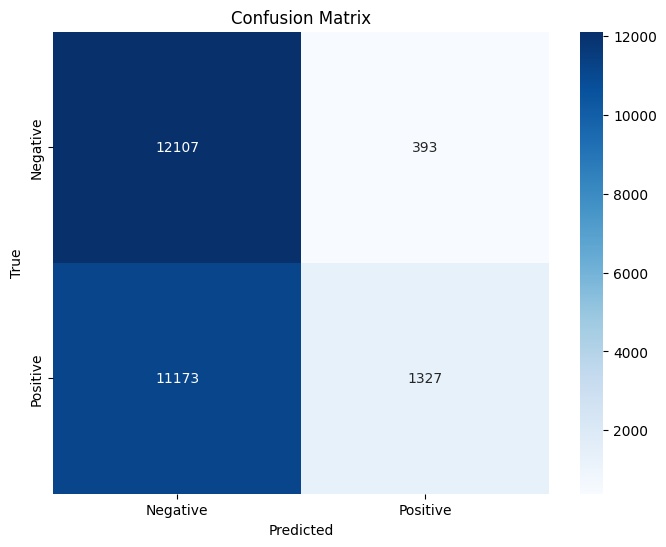

In [ ]:
# 训练参数
EPOCHS = 4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()

# 主训练循环
for epoch in range(EPOCHS):
    print(f"Epoch {epoch + 1}/{EPOCHS}")

    # 训练
    train_loss = train_epoch(model, train_loader, optimizer, device, criterion)
    print(f"Training Loss: {train_loss:.4f}")

    # 评估
    val_loss, val_accuracy = evaluate(model, val_loader, device, criterion)
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # 学习率调整
    scheduler.step()

# 性能评估
test_loss, test_accuracy = evaluate(model, test_loader, device, criterion)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# 获取真实标签和预测标签
all_preds = []  # 存放预测值
all_labels = []  # 存放真实值

for batch in test_loader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['targets'].to(device)

    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    preds = torch.argmax(outputs, dim=1).cpu().numpy()
    all_preds.extend(preds)
    all_labels.extend(labels.cpu().numpy())

# 性能评估
evaluate_performance(all_labels, all_preds)

准确率低 -> 调小学习率避免梯度爆炸

不收敛 -> 增加训练轮数


在训练模型的过程中，我对以下超参数进行了调整：

1. 批量大小（Batch Size）
设置依据：根据 GPU 显存的限制，调整批量大小以确保不会出现显存溢出。
调整方式：从初始的批量大小（16）逐步减少到 8，发现训练速度较快且不会导致显存溢出。
最终设置：批量大小为 8，经过调整后稳定运行。
2. 学习率（Learning Rate）
设置依据：初始设置为 5e-5，这是 Transformer 模型常用的学习率，符合大多数预训练模型的经验值。
调整方式：学习率过大会导致模型训练不稳定，过小则收敛速度太慢。为了避免过拟合，我调低了学习率至 2e-5，并使用了 StepLR 进行动态调整。
最终设置：学习率为 2e-5，使用 StepLR 调度器，每 2 个 epoch 后降低学习率。
3. Dropout 比例
设置依据：为了防止过拟合，特别是在数据量较小或模型较大时，增加 Dropout 比例。
调整方式：在初始模型中加入了 Dropout 层，并在后期尝试不同的概率（如 0.3、0.4）以获得更好的验证性能。
最终设置：设置为 0.4，以平衡训练集和验证集的性能。

后续可尝试的实验：创建加权交叉熵损失函数